In [1]:
%matplotlib inline
import sys, os, glob
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.coordinates import concatenate
plt.rcParams['axes.linewidth'] = 1.5
from astropy.io import fits

In [2]:
from taufit.taufit import fit_drw, fit_celerite, hampel_filter, plot_celerite
import corner

In [3]:
import healpy as hp
# Load healpix pixels
hpixs_gw = np.loadtxt('/data/des80.a/data/cburke/hpix_90_1024_nest.dat')

In [4]:
from astropy.io.ascii import read as read_ascii
data_ztf = read_ascii('/data/des80.a/data/cburke/ztf_dr3.dat', format='ipac')
coord_ztf = SkyCoord(data_ztf['ra'], data_ztf['dec'])

In [5]:
from qlf import compute

The code block below computes the QLF from Hopkins et al at various redshifts:

In [18]:
import os, subprocess
import numpy as np

def bash(command, print_out=True):
    command = "!"+command
    if print_out: print(command)
    return subprocess.Popen(command.split())
    
def compute(nus, redshifts, fit_key=0):
    """
    Computes the qusar luminosity function at given frequencies and redshifts
    
    This python function is a wrapper for Phil Hopkins' C program:
    http://www.tapir.caltech.edu/~phopkins/Site/qlf.html
    
    Input:
        1 : nu -- the *rest frame* frequency of interest. for a specific band computed in 
            HRH06, enter :
                0.0 = bolometric, -1.0 = B-band, -2.0 = mid-IR (15 microns)
               -3.0 = soft X-ray (0.5-2 keV), -4.0 = hard X-ray (2-10 keV)
            otherwise, give nu in Hz, which is taken to be the effective 
            frequency of the band (for which attenuation, etc. is calculated)
            
        2 : redshift -- the redshift of the luminosity function to be returned
        
        3
    
    Returns:
        1 : observed luminosity in the band, in (log_{10}(L [erg/s]))
                (luminosities output are nu*L_nu, unless the bolometric, 
                 soft X-ray, or hard X-ray flags are set, in which case the luminosities 
                 are integrated over the appropriate frequency range)

        2 : corresponding absolute monochromatic AB magnitude at the given frequency nu. 
                (for bolometric, soft and hard X-ray bands which are integrated 
                 over some frequency range, this adopts effective frequencies of 
                 2500 Angstrom, 1 keV and 5 keV, respectively -- these are totally 
                 arbitrary, of course, but the AB magnitude is not well defined 
                 in any case for these examples). 

        3 : corresponding observed monochromatic flux in (log_{10}(S_nu [milliJanskys])) 
                (i.e. log_{10}( S_nu [10^-26 erg/s/cm^2/Hz] ))
                (This calculates the flux with the luminosity distance appropriate for the 
                 adopted cosmology in HRH06: Omega_Matter=0.3, Omega_Lambda=0.7, h=0.7. 
                 Attentuation from observed column density distributions is included, 
                 as described in the paper, but intergalactic attentuation appropriate 
                 near Lyman-alpha, for example, is NOT included in this calculation. 
                 Be careful, as this also does NOT include the K-correction, defined as : 
                      m = M + (distance modulus) + K
                      K = -2.5 * log[ (1+z) * L_{(1+z)*nu_obs} / L_{nu_obs} ]
                 For the bolometric, soft and hard X-rays, this returns the 
                 integrated flux over the 
                 appropriate frequency ranges, in CGS units (erg/s/cm^2).)

        4 : corresponding bolometric luminosity (given the median bolometric 
                corrections as a function of luminosity), in (log_{10}(L [erg/s]))

        5 : comoving number density per unit log_{10}(luminosity) : 
                dphi/dlog_{10}(L)  [ Mpc^{-3} log_{10}(L)^{-1} ]
                (make sure to correct by the appropriate factor to convert to e.g. 
                 the number density per unit magnitude) 
    """
    
    
    # Get the path to the c file
    qlf_calculator_path = "/home/s1/cburke/qlf/"
    qlf_command = os.path.join(qlf_calculator_path, "qlf_calculator")
    qlf_fileout = "/home/s1/cburke/qlf/out.txt"
    # Run the calculator in grid of nu and redshift
    for nu in np.asarray([nus]).flatten():
        for redshift in np.asarray([redshifts]).flatten():
            # Execute command
            out = !eval {"%s %f %f %d >> %s" % (qlf_command, nu, redshift, fit_key, qlf_fileout)}
    
    # Read the output
    qlf_out = np.loadtxt(qlf_fileout)
    observed_luminosity = qlf_out[:,0]
    magAB = qlf_out[:,1]
    S_nu = qlf_out[:,2]
    bolometric_luminosity = qlf_out[:,3]
    comoving_number_density = qlf_out[:,4] # dphi/dlog_{10}(L)  [ Mpc^{-3} log_{10}(L)^{-1} ]
    
    return observed_luminosity, magAB, S_nu, bolometric_luminosity, comoving_number_density

In [40]:
# Output example
!/home/s1/cburke/qlf/qlf_calculator 0 1

 nu = 0.0 (returning bolometric QLF) 
 redshift = 1.000000 
 fit_key = 0 : 'Full' bolometric QLF fit 
                 (see Table 3 of HRH06; best-fit model) 
                  (allows both bright and faint-end slopes to evolve with redshift) 
                    chi^2/nu = 1007/508  (with respect to the compiled observations therein) 
 Output : L_obs    M_AB_nu    S_nu     L_bol     phi 
    L_obs   = observed L in band, in log_{10}(L/[erg/s]) 
               (integrated over the appropriate bandpass) 
    M_AB_nu = monochromatic AB absolute magnitude 
               (effective wavelength chosen arbitrarily at 2500 Angstroms) 
    S       = observed flux (integrated over the bandpass), 
                in CGS units (erg/s/cm^2) 
    L_bol   = (roughly) corresponding bolometric L, from the 
                median bolometric corrections adopted 
    phi     = number density per unit log_{10}(L), in Mpc^{-3} 
 41.600000 -14.707766 7.607976e-17 41.600000 4.567457e-03 
 41.700000 -14.95776

In [21]:
dz = 0.01 # redshift spacing
z = np.arange(dz, 6, dz)
_observed_luminosity, magAB, _S_nu, _bolometric_luminosity, _comoving_number_density = compute(0, z)

$ \phi = \int \frac{d \phi(L) }{ d\log(L) } d\log(L) $

$ \phi = \int d \phi(L)  $

$ \phi_{\rm det} = \int_{L_{\rm det}}^{L_\infty} d \phi(L)  $

In [101]:
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# comoving_number_density: dphi/dlog_{10}(L)  [ Mpc^{-3} log_{10}(L)^{-1} ]
comoving_number_density = _comoving_number_density*u.Mpc**-3 # dphi/dlog_{10}(L)  [ Mpc^{-3} log_{10}(L)^{-1} ]

# This is the volume of the universe encompassed by redshifts < z
dV = cosmo.differential_comoving_volume(z) # dV / (dz dOmega) [Mpc3 / sr / redshift]
dOmega = 774*u.deg**2 # 90% CI
dV = (dV*dOmega).to(u.Mpc**3) # dV/dz

# Flux-limited sample
# compute f_nu at AB mag 23
f_nu_det = (19*u.ABmag).to(u.erg/u.s/u.cm**2/u.Hz)
filter_lam = 806*u.nm # i-band
nu = (const.c/filter_lam).to(u.Hz)
# Compute flux at AB mag 
f_det = f_nu_det * nu
# Compute luminosity of AGNs we can detect at each z
d_L = cosmo.luminosity_distance(z).to(u.cm) # unit cm
L_det = f_det*4.*np.pi*d_L**2
L_det = L_det.to(u.erg/u.s)
# Assume bolometric L is 10* i-band L
L_bol_det = 10*L_det

# Create a grid phi(L,z) at L and z
phi_grid = np.empty([len(_bolometric_luminosity)//len(z), len(z)])

dlogL = 0.1 # Luminosity spacing
log_L_bol_eval = np.sort(np.unique(_bolometric_luminosity)) # Discrete luminosities at which phi is evaluated
phi_det = np.empty(len(z)) # Detectable number density of AGNs

# For each phi at L and redshift z
for i, zi in enumerate(z):
    for j, logL_j in enumerate(log_L_bol_eval):
        # Get phi at specific L for all redshifts zi
        # phi = dphi/dlogL * dlogL
        phi_grid[j,i] = comoving_number_density.value[_bolometric_luminosity==logL_j][i]*dlogL
    
    # detection luminosity level at redshift zi (flux limited)
    log_L_bol_det = np.log10(L_bol_det[i].value)
    
    # Sum all luminosities larger than the detection L
    phi_det[i] = np.sum(phi_grid[log_L_bol_eval>log_L_bol_det,i]) # \int_{Lbol_det}^{Lbol_infty} dphi (L)
    
    # Interpolate at L_det
    #phi_det[i] = np.interp(log_L_bol_det, log_L_bol_eval, phi_grid[:,i]) #*dlogL

# Add units
phi_det = phi_det*u.Mpc**-3

### Plot L versus redshift

Plot $\phi(L)$ in luminosity intervals (Figure 9. of Hopkins et al.)

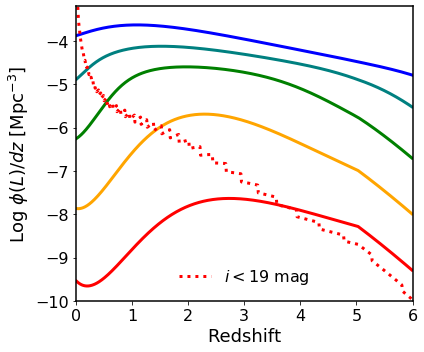

In [106]:
# Convert comoving number density to number
fig,ax = plt.subplots(1,1, figsize=(6,5), sharey=True)
# comoving_number_density is d phi(L) / d logL
# phi(L) = integral d phi(L) / d logL * d logL [Mpc^-3]
logL = 44.0
Lbin = 10 # Width of luminosity interval
ax.plot(z, np.log10(comoving_number_density.value[_bolometric_luminosity==logL]*dlogL*Lbin), lw=3, c='b')
logL = 45.0
ax.plot(z, np.log10(comoving_number_density.value[_bolometric_luminosity==logL]*dlogL*Lbin), lw=3, c='teal')
logL = 46.0
ax.plot(z, np.log10(comoving_number_density.value[_bolometric_luminosity==logL]*dlogL*Lbin), lw=3, c='g')
logL = 47.0
ax.plot(z, np.log10(comoving_number_density.value[_bolometric_luminosity==logL]*dlogL*Lbin), lw=3, c='orange')
logL = 48.0
ax.plot(z, np.log10(comoving_number_density.value[_bolometric_luminosity==logL]*dlogL*Lbin), lw=3, c='r')

# Plot detection number density
ax.plot(z, np.log10(phi_det.value), lw=3, color='r', linestyle='dotted', label='$i<19$ mag')

ax.tick_params('both', labelsize=16)

ax.set_xlim(0, 6)
ax.set_ylim(-10, -3.2)
ax.set_xlabel(r'Redshift', fontsize=18)
ax.set_ylabel(r'Log $\phi(L)/dz$ [Mpc$^{-3}$]', fontsize=18)

ax.legend(frameon=False, fontsize=16)

fig.tight_layout()

Looks like we can reproduce the correct result!

Num. of AGN at z< 1:  12440.359105408965


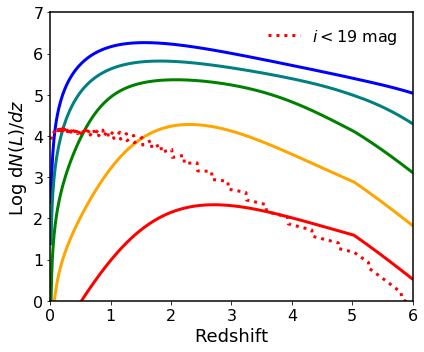

In [105]:
# Convert comoving number density to number
fig,ax = plt.subplots(1,1, figsize=(6,5), sharey=True)

logL = 44.0
Lbin = 10 # Width of luminosity interval
ax.plot(z, np.log10(comoving_number_density.value[_bolometric_luminosity==logL]*dlogL*Lbin*dV.value), lw=3, c='b')
logL = 45.0
ax.plot(z, np.log10(comoving_number_density.value[_bolometric_luminosity==logL]*dlogL*Lbin*dV.value), lw=3, c='teal')
logL = 46.0
ax.plot(z, np.log10(comoving_number_density.value[_bolometric_luminosity==logL]*dlogL*Lbin*dV.value), lw=3, c='g')
logL = 47.0
ax.plot(z, np.log10(comoving_number_density.value[_bolometric_luminosity==logL]*dlogL*Lbin*dV.value), lw=3, c='orange')
logL = 48.0
ax.plot(z, np.log10(comoving_number_density.value[_bolometric_luminosity==logL]*dlogL*Lbin*dV.value), lw=3, c='r')


dN_det = phi_det*dV # dN/dz/dlogL
ax.plot(z, np.log10(dN_det), lw=3, color='r', linestyle='dotted', label='$i<19$ mag')
print('Num. of AGN at z< 1: ', np.sum(dN_det[z<1]*dz))

ax.tick_params('both', labelsize=16)

ax.set_xlim(0, 6)
ax.set_ylim(0, 7)
ax.set_xlabel(r'Redshift', fontsize=18)
ax.set_ylabel(r'Log d$N(L)/dz$', fontsize=18)

ax.legend(frameon=False, fontsize=16)

fig.tight_layout()

### Read Milliquas Catalog

In [82]:
from astropy.table import Table
filepath_mqc = "/data/des80.a/data/cburke/milliquas.txt"
table_mqc = Table.read(filepath_mqc, format="ascii.cds")
# Coords
coord_mqc = SkyCoord(table_mqc['RA'], table_mqc['DEC'], unit=u.deg)

In [83]:
table_mqc

RA,DEC,Name,Descrip,Rmag,Bmag,Comment,R,B,Z,Cite,Zcite,Qpct,Xname,Rname,Lobe1,Lobe2
deg,deg,,,mag,mag,,,,z,,,pct,,,,
float64,float64,str25,str4,float64,float64,str3,str1,str1,float64,str6,str6,int64,str22,str22,str22,str22
0.0006286,35.5178439,SDSS J000000.15+353104.2,Q,17.93,19.0,pG,-,-,0.845,DR16Q,DR16,--,--,--,--,--
0.0006575,-20.074344,UVQSJ000000.15-200427.7,AX,17.9,18.46,pG,-,1,0.291,UVQS,UVQS,97,2SXPS J000000.1-200427,--,2RXS J000000.7-200446,--
0.0014146,31.0570479,SDSS J000000.33+310325.3,Q,19.95,21.29,j,-,-,2.035,DR16Q,DR16,--,--,--,--,--
0.0014297,-41.4929974,WISEA J000000.33-412934.9,q,18.51,19.21,jG,-,-,2.4,WISEA,MQ,100,--,--,--,--
0.0015265,27.7322834,SDSS J000000.36+274356.2,Q,21.75,21.91,g,-,-,1.771,DR16Q,DR16,--,--,--,--,--
0.0015354,7.0641294,SDSS J000000.36+070350.8,Q,21.87,22.11,g,-,-,1.574,DR16Q,DR16,--,--,--,--,--
0.0018983,17.7737392,SDSS J000000.45+174625.4,Q,22.07,21.91,g,-,-,2.309,DR16Q,DR16Q,--,--,--,--,--
0.0019186,9.3856563,SDSS J000000.45+092308.2,Q,18.58,18.87,pG,-,-,2.024,DR16Q,DR16,--,--,--,--,--


### Read GW sky map

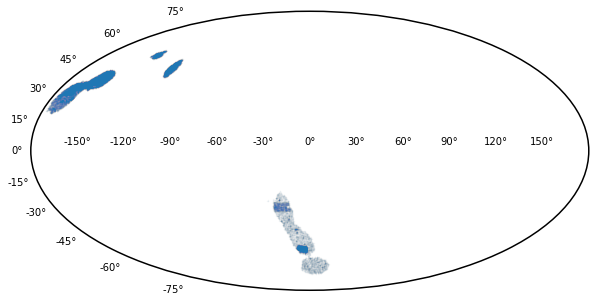

In [84]:
import astropy.coordinates as coord

hpixs_mqc = hp.ang2pix(1024, table_mqc['RA'], table_mqc['DEC'], nest=True, lonlat=True)
mask = np.isin(hpixs_mqc, hpixs_gw)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='mollweide')

ra = coord.Angle(table_mqc['RA'][mask])
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(table_mqc['DEC'][mask])
ax.scatter(ra.radian, dec.radian, s=.1, alpha=0.03)

# Plot ZTF
#ax.scatter(coord_ztf.ra.radian, coord_ztf.dec.radian, s=.1, alpha=0.03)
#plt.show()

In [85]:
unobscured_class = ['Q','A'] # These all have spectroscpic redshifts
mask_unobscured = np.isin(table_mqc['Descrip'][mask], unobscured_class)

redshift = table_mqc['Z'][mask]
mag = table_mqc['Rmag'][mask]

In [86]:
len(redshift)

50061

In [87]:
len(redshift[redshift<1.1])

18268

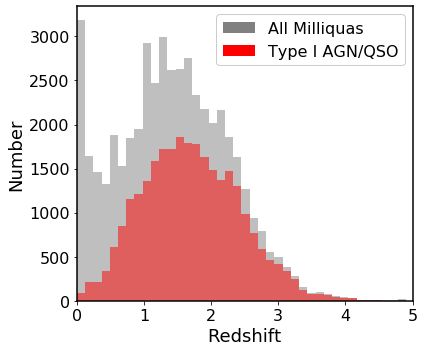

In [88]:
fig,ax = plt.subplots(1,1, figsize=(6,5), sharey=True)

ax.hist(redshift[(mag>5)], color='grey', alpha=0.5, bins=50, label='All Milliquas')
ax.hist(redshift[mask_unobscured & (mag>5)], color='r', alpha=0.5, bins=50, label='Type I AGN/QSO')

ax.tick_params('both', labelsize=16)

ax.set_xlim(0, 5)
#ax.set_ylim(6, 25)
ax.set_xlabel(r'Redshift', fontsize=18)
ax.set_ylabel(r'Number', fontsize=18)

legend = ax.legend(fontsize=16, framealpha=1, loc=1)
for lh in legend.legendHandles:
    lh.set_alpha(1)

fig.tight_layout()

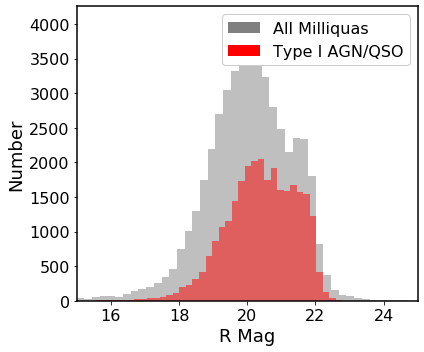

In [89]:
fig,ax = plt.subplots(1,1, figsize=(6,5), sharey=True)

ax.hist(mag[(mag>5)], color='grey', alpha=0.5, bins=80, label='All Milliquas')
ax.hist(mag[mask_unobscured & (mag>5)], color='r', alpha=0.5, bins=80, label='Type I AGN/QSO')

ax.tick_params('both', labelsize=16)

ax.set_xlim(15, 25)
#ax.set_ylim(6, 25)
ax.set_xlabel(r'R Mag', fontsize=18)
ax.set_ylabel(r'Number', fontsize=18)

legend = ax.legend(fontsize=16, framealpha=1, loc=1)
for lh in legend.legendHandles:
    lh.set_alpha(1)

fig.tight_layout()

### Compare QLF to Milliquas

[4820 2781 3414 3788 5394 5610 5381 4513 4180 3485 2219 1346  880  435
  188  132   67   24   12   27    8    1    3    2    3]
599 599


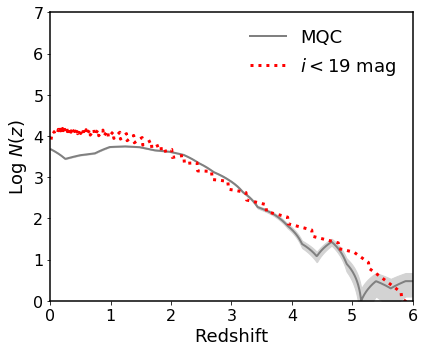

In [104]:
# Now get the incompleteness

# Pick a quasar lumonisity
L = 43.5

# Convert comoving number density to number

from astropy.stats import histogram as hist

z_hist, bin_edges = hist(redshift[(mag>5)], bins=25)
print(z_hist)

z_hist = np.interp(z, bin_edges[:-1], z_hist)
print(len(z_hist), len(z))

fig,ax = plt.subplots(1,1, figsize=(6,5), sharey=True)


ax.plot(z, np.log10(z_hist), c='grey', lw=2, label='MQC')
ax.fill_between(z, np.log10(z_hist+np.sqrt(z_hist)), np.log10(z_hist-np.sqrt(z_hist)),color='lightgrey', lw=1)

ax.plot(z, np.log10(dN_det), lw=3, color='r', linestyle='dotted', label='$i<19$ mag')



ax.tick_params('both', labelsize=16)

ax.set_xlim(0, 6)
ax.set_ylim(0, 7)
ax.set_xlabel(r'Redshift', fontsize=18)
#ax.set_ylabel(r'Log $\phi(z)$ [Mpc$^{-3}$]', fontsize=18)
ax.set_ylabel(r'Log $N(z)$', fontsize=18)

ax.legend(frameon=False, fontsize=18)


fig.tight_layout()

### Scratch Stuff Below

558548.5843222946
4324.684692352918


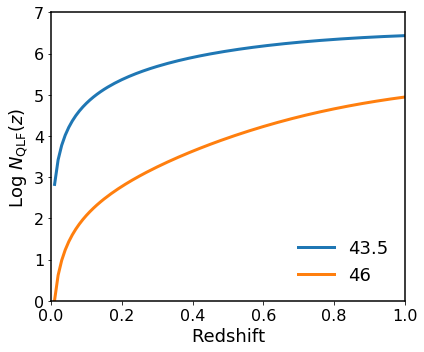

In [161]:
# Now get the incompleteness

# Pick a quasar lumonisity
L = 43.5

fig,ax = plt.subplots(1,1, figsize=(6,5), sharey=True)
y43_5 = np.log10(comoving_number_density[_bolometric_luminosity==L]*V)# - z_hist)
y43_5[np.isnan(y43_5)] = 0
ax.plot(z, y43_5, lw=3, label='43.5')

print(10**np.sum(y43_5[z<1]*dz))

L = 46
y46 = np.log10(comoving_number_density[_bolometric_luminosity==L]*V) # - z_hist)
y46[np.isnan(y46)] = 0
ax.plot(z, y46, lw=3, label='46')

print(10**np.sum(y46[z<1]*dz))

ax.tick_params('both', labelsize=16)

ax.set_xlim(0, 1)
ax.set_ylim(0, 7)
ax.set_xlabel(r'Redshift', fontsize=18)
#ax.set_ylabel(r'Log $\phi(z)$ [Mpc$^{-3}$]', fontsize=18)
ax.set_ylabel(r'Log $N_{\rm{QLF}}(z)$', fontsize=18)

ax.legend(frameon=False, fontsize=18)


fig.tight_layout()

In [25]:
data = fits.open('lc.fits')[1].data
df_crts = pd.read_csv('lc_crts.csv')
df_ps = pd.read_csv('lc_ps.csv')
df_ps = df_ps[df_ps['filterID']==1]
mag_ps = 8.90 -2.5*np.log10(df_ps['psfFlux'].values)
magerr_ps = 2.5/np.log(10)*df_ps['psfFluxErr'].values/df_ps['psfFlux'].values

In [26]:
g2V = -0.52

x = np.concatenate([data['mjd'], df_crts['MJD'].values, df_ps['obsTime'].values])
y = np.concatenate([data['mag'] + g2V, df_crts['Mag'].values, mag_ps + g2V])
yerr = np.concatenate([data['magerr'], df_crts['Magerr'].values, magerr_ps])

In [27]:
# sort
idx = np.argsort(x)
x = x[idx]
y = y[idx]
yerr = yerr[idx]

# filter outliers
x, y, outlier_mask = hampel_filter(x, y, 50, n_sigmas=3)
yerr = yerr[~outlier_mask]

# Add SDSS point
x = np.concatenate([[53111], x])
y = np.concatenate([[18.899 + g2V], y])
yerr = np.concatenate([[0.009], yerr])

In [28]:
x = x*u.day
y = y*u.mag
yerr = yerr*u.mag

Initial log-likelihood: 1857.7529571665495
Final log-likelihood: 2050.7819203678396
Running burn-in...
Running production...


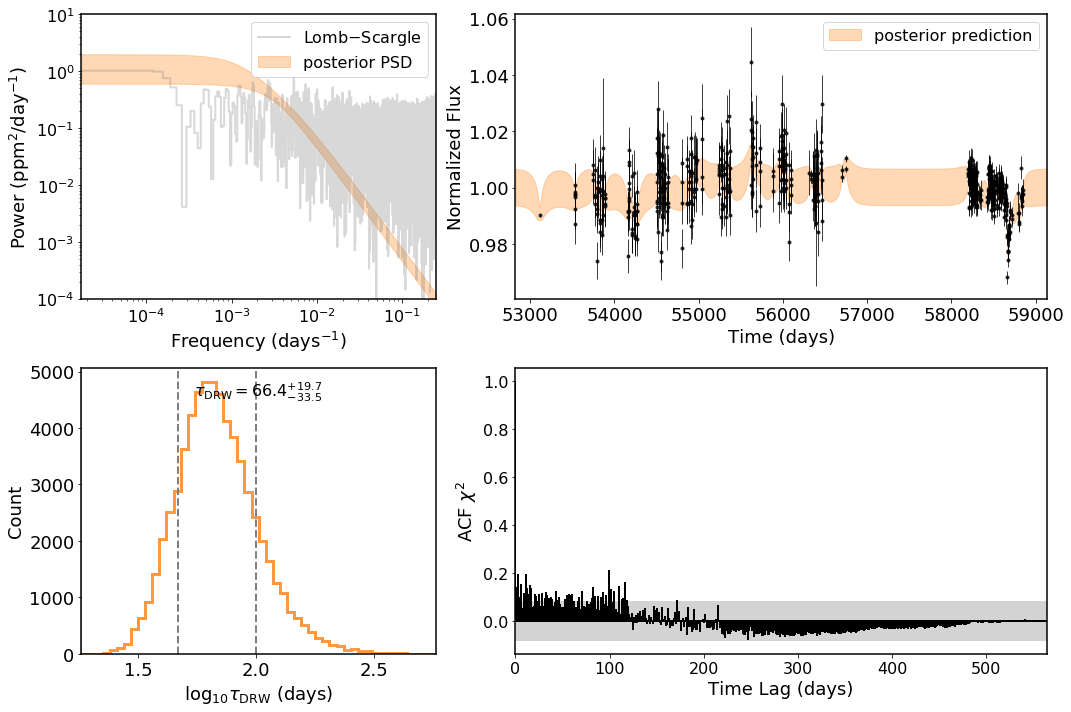

(<celerite.celerite.GP at 0x7fe3b5d0d790>,
 array([[-10.12984222,  -3.98250458],
        [ -9.28496392,  -4.91506163],
        [ -9.9685142 ,  -3.25556311],
        ...,
        [ -9.17131612,  -5.16935279],
        [ -9.71811075,  -4.39481465],
        [-10.21488382,  -4.64627392]]),
 <Figure size 1080x720 with 4 Axes>)

In [21]:
fit_drw(x, y/np.median(y), yerr/np.median(y))

In [29]:
import warnings
import celerite
from celerite import terms
import emcee
from astropy.timeseries import LombScargle
from scipy.optimize import minimize, differential_evolution

Fit the data without the flare (<58000)

In [39]:
nburn=500
nsamp=2000

# Sort data
ind = np.argsort(x)
x = x[ind]; y = y[ind]; yerr = yerr[ind]
baseline = x[-1]-x[0]

mask = x < 58650*u.day
x_mask = x[mask]
y_mask = y[mask]
yerr_mask = yerr[mask]

# Use uniform prior with default 'smart' bounds:
min_precision = np.min(yerr.value)
amplitude = np.max(y.value+yerr.value)-np.min(y.value-yerr.value)
amin = np.log(0.01*min_precision)
amax = np.log(10*amplitude)
log_a = np.mean([amin,amax])

min_cadence = np.clip(np.min(np.diff(x.value)), 0.1, None)
cmin = np.log(1/(10*baseline.value))
cmax = np.log(1/min_cadence)
log_c = np.mean([cmin,cmax])

smin = -10
smax = np.log(amplitude)
log_s = np.mean([smin,smax])

kernel = terms.RealTerm(log_a=log_a, log_c=log_c,
                    bounds=dict(log_a=(amin, amax), log_c=(cmin, cmax)))

# Add jitter term
#kernel += terms.JitterTerm(log_sigma=log_s, bounds=dict(log_sigma=(smin, smax)))

# Set seed for reproducability
np.random.seed(42)

gp = celerite.GP(kernel, mean=np.mean(y_mask.value), fit_mean=False)
gp.compute(x_mask.value, yerr_mask.value)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y_mask.value)))

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

# MLE solution
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y_mask.value, gp))
initial = np.array(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

gp.set_parameter_vector(initial)

# Define the log probablity
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(y_mask) + lp

ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, nburn)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, nsamp);

# Get posterior and uncertianty
samples = sampler.flatchain

s = np.median(samples, axis=0)
gp.set_parameter_vector(s)

Initial log-likelihood: 351.60221718123364
Final log-likelihood: 378.3427734961093
Running burn-in...
Running production...


In [40]:
color = "#ff7f0e"
target_name = "J1249+3449"

kernel = gp.kernel

baseline = x_mask[-1]-x_mask[0]
cadence = np.mean(np.diff(x_mask))

s = np.median(samples, axis=0)
gp.set_parameter_vector(s)

pad = 0.05*baseline.value # 5% padding for plot
t = np.linspace(np.min(x.value) - pad, np.max(x.value) + pad, 500)

mu, var = gp.predict(y_mask.value, t, return_var=True)
std = np.sqrt(var)
# Noise level
noise_level = 2.0*np.median(np.diff(x_mask.value))*np.mean(yerr_mask.value**2)

# Lomb-Scargle periodogram with PSD normalization
freqLS, powerLS = LombScargle(x_mask, y_mask, yerr_mask).autopower(normalization='psd')
powerLS /= len(x_mask)
f = np.logspace(np.log10(np.min(freqLS.value)), np.log10(np.max(freqLS.value)), 1000)/u.day

# The posterior PSD
psd_samples = np.empty((len(f), len(samples)))
for i, s in enumerate(samples):
    gp.set_parameter_vector(s)
    psd_samples[:, i] = kernel.get_psd(2*np.pi*f.value)/2*np.pi
# Compute credibility interval
psd_credint = np.empty((len(f), 3))
psd_credint[:, 0] = np.percentile(psd_samples, 16, axis=1)
psd_credint[:, 2] = np.percentile(psd_samples, 84, axis=1)
psd_credint[:, 1] = np.median(psd_samples, axis=1)

f_norm = np.max(powerLS.value)/psd_credint[0, 1]

psd_credint[:, 0] = psd_credint[:, 0]*f_norm
psd_credint[:, 2] = psd_credint[:, 2]*f_norm
psd_credint[:, 1] = psd_credint[:, 1]*f_norm

d


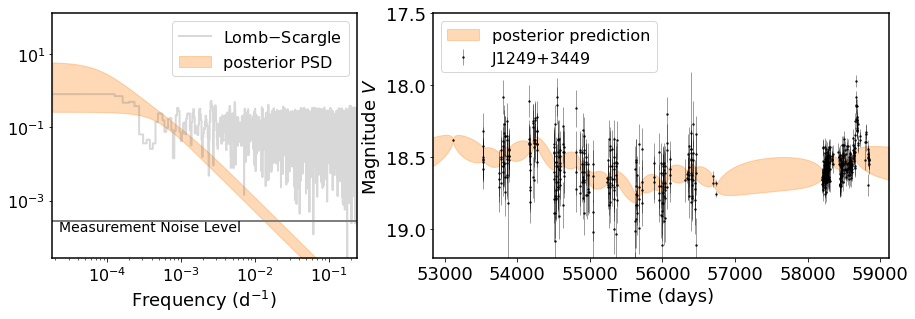

In [41]:
# Plot
fig, axs = plt.subplots(1,2, figsize=(15,4.5), gridspec_kw={'width_ratios': [1, 1.5]})
# PSD
axs[0].set_xlim(np.min(freqLS.value), np.max(freqLS.value))
axs[0].loglog(freqLS, powerLS, c='grey', lw=2, alpha=0.3, label=r'Lomb$-$Scargle', drawstyle='steps-pre')
axs[0].fill_between(f, psd_credint[:, 2], psd_credint[:, 0], alpha=0.3, label='posterior PSD', color=color)
xlim = axs[0].get_xlim()
axs[0].hlines(noise_level, xlim[0], xlim[1], color='grey', lw=2)
axs[0].annotate("Measurement Noise Level", (1.25 * xlim[0], noise_level / 1.9), fontsize=14)
#axs[0].set_ylabel("Power (mag$^2 / $day$^{-1}$)", fontsize=18)

#axs[0].set_ylabel("Power (${0.unit:s}^2 / {0.unit:s}^{-1}$)".format(x[0], y[0]), fontsize=18)
unitstr = "{0.unit:}".format(x[0])
print(unitstr)
axs[0].set_xlabel("Frequency (%s$^{-1}$) " % unitstr, fontsize=18)

#axs[0].set_xlabel("Frequency (days$^{-1}$)", fontsize=18)
axs[0].tick_params('both', labelsize=16)
axs[0].legend(fontsize=16, loc=1)
axs[0].set_ylim(noise_level / 10.0, 10*axs[0].get_ylim()[1])

# Light curve & prediction
axs[1].errorbar(x.value, y.value, yerr=yerr.value, c='k', fmt='.', alpha=0.75, elinewidth=.5, ms=3, label=target_name)
axs[1].fill_between(t, mu+std, mu-std, color=color, alpha=0.3, label='posterior prediction')

axs[1].set_xlabel("Time (days)", fontsize=18)
axs[1].set_ylabel('Magnitude $V$', fontsize=18)
axs[1].tick_params(labelsize=18)
axs[1].set_ylim([17.5, 19.2])
axs[1].invert_yaxis()
axs[1].set_xlim(np.min(t), np.max(t))
axs[1].legend(fontsize=16, loc=2)

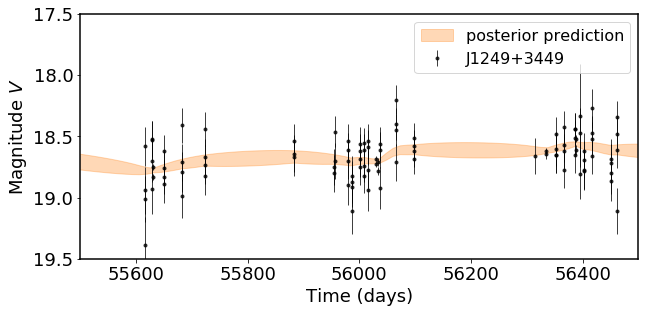

In [43]:
# Plot
fig, ax = plt.subplots(1,1, figsize=(10,4.5))

# Light curve & prediction
ax.errorbar(x.value, y.value, yerr=yerr.value, c='k', fmt='.', alpha=0.75, elinewidth=1, label=target_name)
ax.fill_between(t, mu+std, mu-std, color=color, alpha=0.3, label='posterior prediction')

ax.set_xlabel("Time (days)", fontsize=18)
ax.set_ylabel('Magnitude $V$', fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim([17.5, 19.5])
ax.invert_yaxis()
ax.set_xlim(55500, 56500)
ax.legend(fontsize=16, loc=1)

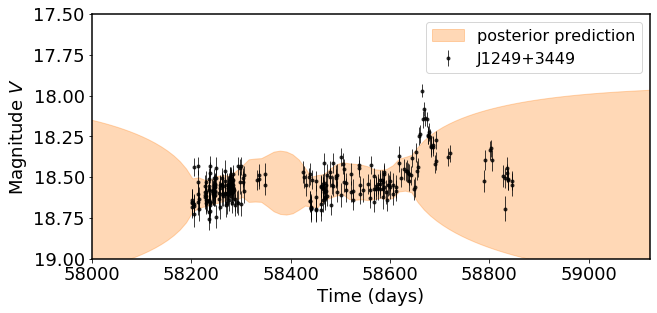

In [45]:
# Plot
fig, ax = plt.subplots(1,1, figsize=(10,4.5))

# Light curve & prediction
ax.errorbar(x.value, y.value, yerr=yerr.value, c='k', fmt='.', alpha=0.75, elinewidth=1, label=target_name)
ax.fill_between(t, mu+5*std, mu-5*std, color=color, alpha=0.3, label='posterior prediction')

ax.set_xlabel("Time (days)", fontsize=18)
ax.set_ylabel('Magnitude $V$', fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim([17.5, 19.0])
ax.invert_yaxis()
ax.set_xlim(58000, np.max(t))
ax.legend(fontsize=16, loc=1)

In [297]:
18.6-5*np.std(y.value)

17.78827876808446

In [280]:
z = 0.438
tau_obs = np.median(1/np.exp(samples[:,1]))
tau_rest = tau_obs*(1 + z)**(-1)
print(tau_rest, tau_obs)
print(baseline)
print(baseline.value > 10*tau_obs)

519.9666341074374 747.7120198464949
5537.183784699999 d
False


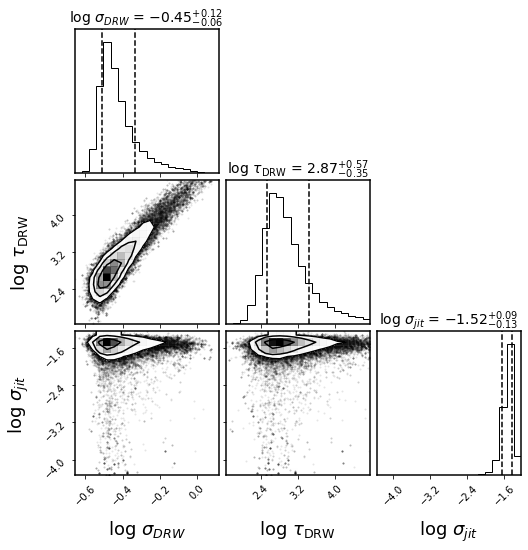

In [279]:
import corner
# Note these are natural logs
# Structure function variables
# sigma = sqrt(a/2), tau_DRW = 1/c, SFinf = sigma_hat*np.sqrt(tau/250)
samples_sf = [np.log10(np.sqrt(np.exp(samples[:,0]/2))), np.log10(1/np.exp(samples[:,1])), np.log10(np.exp(samples[:,2]))]
samples_sf = np.array(samples_sf).T

fig = corner.corner(samples_sf, quantiles=[0.16,0.84], show_titles=True,
            labels=[r"$\log\ \sigma_{DRW}$", r"$\log\ \tau_{\rm{DRW}}$", r"$\log\ \sigma_{jit}$"],
            label_kwargs=dict(fontsize=18), title_kwargs=dict(fontsize=14));